In [154]:
import pandas as pd
import yfinance as yf
import numpy as np 
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import datetime

from pymongo import MongoClient
import os
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [130]:
load_dotenv()

MONGO_URI = os.getenv("MONGO_URI")
if not MONGO_URI:
    raise ValueError("MONGO_URI environment variable is not set.")

client = MongoClient(MONGO_URI)
db = client["stocks_db"]
collection = db["daily_prices"]

# Cointegration

In [131]:
end_date = datetime.datetime.today()
target_start_date = end_date - datetime.timedelta(days=365 * 3)  # 3 years ago

print(f"Using a 3-year lookback window: {target_start_date.date()} to {end_date.date()}")

pipeline = [
    {
        "$group": {
            "_id": "$ticker",
            "min_date": {"$min": "$date"}
        }
    },
    {
        "$match": {
            "min_date": {"$lte": target_start_date}
        }
    }
]

try:
    # Execute the pipeline and convert the result to a list
    results = list(collection.aggregate(pipeline))
    
    # Extract just the ticker names from the aggregation results
    tickers_since_start_date = [doc['_id'] for doc in results]

    if tickers_since_start_date:
        print(f"\nFound {len(tickers_since_start_date)} tickers with data since {target_start_date.date()}.")
        print("Here are the first 50:")
        print(tickers_since_start_date[:50])
    else:
        print("No tickers found with data starting on or before the specified date.")

except Exception as e:
    print(f"An error occurred during the database query: {e}")



Using a 3-year lookback window: 2022-08-11 to 2025-08-10

Found 470 tickers with data since 2022-08-11.
Here are the first 50:
['603766.SS', '688578.SS', '600637.SS', '600879.SS', '601077.SS', '688617.SS', '600598.SS', '601608.SS', '600707.SS', '601633.SS', '601888.SS', '688728.SS', '688223.SS', '600038.SS', '603659.SS', '601933.SS', '601825.SS', '600131.SS', '600893.SS', '601236.SS', '603728.SS', '688303.SS', '600050.SS', '605589.SS', '600026.SS', '688336.SS', '600048.SS', '600906.SS', '603986.SS', '688111.SS', '688188.SS', '601958.SS', '600150.SS', '600171.SS', '600372.SS', '601606.SS', '688072.SS', '603179.SS', '688052.SS', '603486.SS', '601111.SS', '601928.SS', '600803.SS', '600025.SS', '688425.SS', '688036.SS', '600062.SS', '600562.SS', '688037.SS', '600036.SS']


In [132]:
# PEARSON CORRELATION MATRIX
if 'tickers_since_start_date' in locals() and tickers_since_start_date:
    query = {
        "ticker": {"$in": tickers_since_start_date},
        "date": {"$gte": target_start_date}
    }
    projection = {"_id": 0, "date": 1, "ticker": 1, "close": 1}
    all_data = pd.DataFrame(list(collection.find(query, projection)))

    if not all_data.empty:
        df = all_data.pivot(index='date', columns='ticker', values='close')
        df.dropna(inplace=True)
        print(f"Price matrix created with {len(df)} common trading days.")
        print("Sample of the price matrix (df):")
        print(df.head())

        print(f"\nGenerating unique pairs from {len(df.columns)} tickers...")
        corr_matrix = df.corr()

        print("Correlation matrix calculation complete.")

        # 2. Generate unique pairs from the tickers that are in the matrix
        print(f"\nGenerating unique pairs from {len(corr_matrix.columns)} tickers...")
        ticker_pairs = combinations(corr_matrix.columns, 2)
        pairs_df = pd.DataFrame(list(ticker_pairs), columns=["ticker1", "ticker2"])
        print(f"Generated {len(pairs_df)} pairs.")

        # 3. Look up the correlation for each pair from the pre-computed matrix.
        # This is much faster than calculating for each pair individually.
        print("\nMapping correlation values to pairs...")
        pairs_df['correlation'] = pairs_df.apply(lambda row: corr_matrix.loc[row['ticker1'], row['ticker2']], axis=1)
        
        print("\nTop 10 most correlated pairs:")
        print(pairs_df.sort_values(by='correlation', ascending=False).head(10))
    else:
        print("No data available for the specified tickers and date range.")
else:
    print("No tickers found with data since start_date. Please check your database or the date filter.")

Price matrix created with 725 common trading days.
Sample of the price matrix (df):
ticker      600000.SS  600004.SS  600007.SS  600008.SS  600009.SS  600010.SS  \
date                                                                           
2022-08-12   6.485101  12.884131  13.253573   2.500824  57.086945   2.187526   
2022-08-15   6.458230  12.698819  13.079545   2.492080  55.876312   2.217492   
2022-08-16   6.440316  12.893886  13.152821   2.500824  56.151901   2.187526   
2022-08-17   6.520932  13.137718  13.354326   2.509568  56.584980   2.177537   
2022-08-18   6.458230  12.825612  13.143661   2.474591  55.807415   2.127593   

ticker      600011.SS  600012.SS  600015.SS  600016.SS  ...  900901.SS  \
date                                                    ...              
2022-08-12   6.479066   5.834681   4.312431   3.105513  ...   0.472909   
2022-08-15   6.667686   5.860884   4.270644   3.088450  ...   0.471940   
2022-08-16   6.799719   5.878353   4.262287   3.096982  ...

In [133]:
pairs_df = pairs_df[pairs_df['correlation'] > 0.95]

In [134]:
pairs_df

,ticker1,ticker2,correlation
194,600000.SS,600919.SS,0.984541
220,600000.SS,601077.SS,0.957583
237,600000.SS,601166.SS,0.981197
248,600000.SS,601229.SS,0.966657
281,600000.SS,601665.SS,0.959909
...,...,...,...
105669,603766.SS,605499.SS,0.958294
106009,603806.SS,688599.SS,0.968139
109160,688223.SS,688599.SS,0.976131
109293,688256.SS,688608.SS,0.959743


In [135]:
def do_regression(ticker1, ticker2):
    X = df[ticker1].values
    y = df[ticker2].values

    X = sm.add_constant(X)  # Add a constant term for the intercept
    model = sm.OLS(y, X).fit()
    alpha,beta = model.params

    residuals = y - (alpha + beta * X[:,1])

    if np.isnan(residuals).any():
        return np.nan

    adf_results = adfuller(residuals)

    return adf_results[0], adf_results[1], beta, alpha

In [136]:
pairs_df[['adf_stat', 'p_value', 'beta', 'alpha']] = pairs_df.apply(lambda row: pd.Series(do_regression(row['ticker1'], row['ticker2'])), axis=1)

In [137]:
pairs_df = pairs_df[pairs_df.p_value < 0.01].sort_values(by='adf_stat')

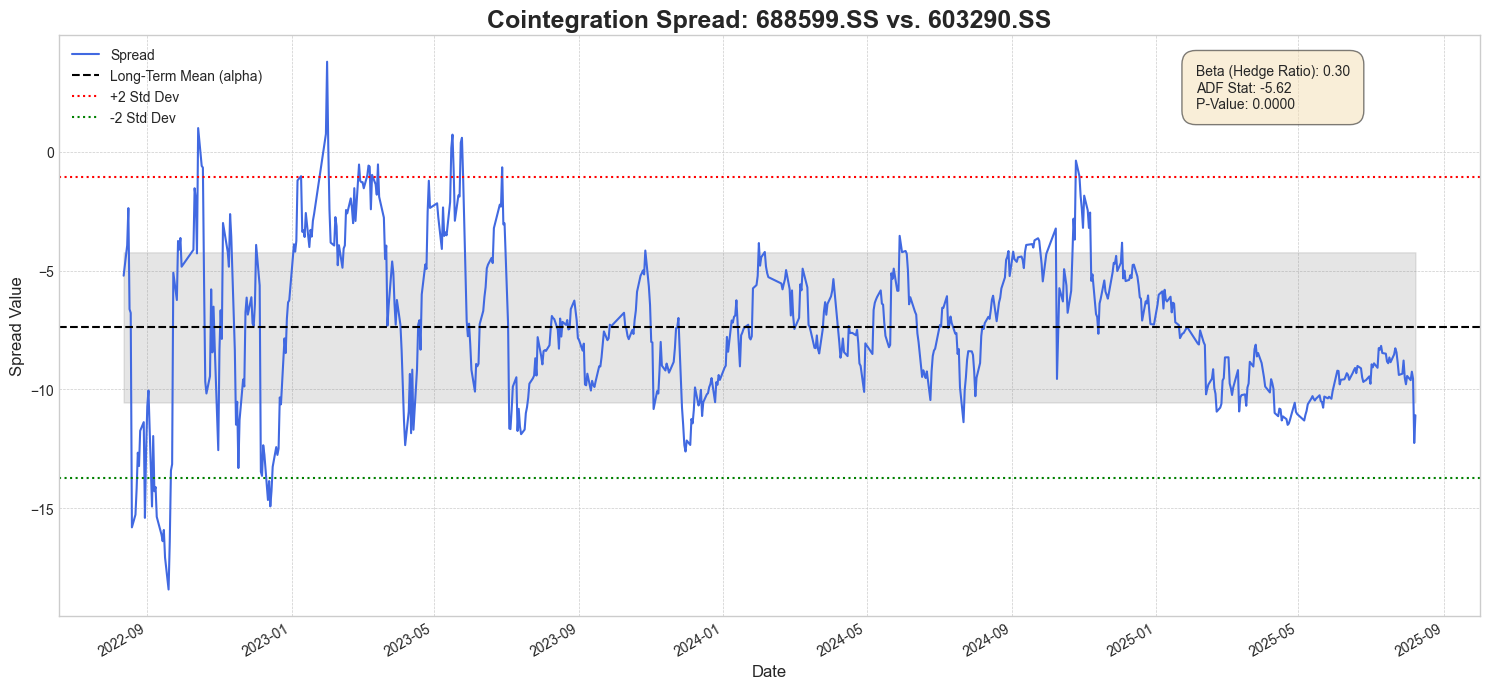

In [138]:
if not pairs_df.empty:
    # 1. Select the top pair (the one with the most negative ADF statistic)
    top_pair = pairs_df.iloc[0]
    ticker1 = top_pair['ticker1']
    ticker2 = top_pair['ticker2']
    beta = top_pair['beta']
    alpha = top_pair['alpha']

    # 2. Calculate the spread using the hedge ratio (beta)
    # The spread is the price of stock 2 minus the hedged price of stock 1
    spread = df[ticker2] - beta * df[ticker1]
    
    # 3. Set a modern plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))

    # 4. Plot the spread over time
    spread.plot(ax=ax, color='royalblue', label='Spread')
    
    # 5. Plot the mean and standard deviation bands for context
    # The mean of the spread is 'alpha' from our regression
    mean_line = ax.axhline(alpha, color='black', linestyle='--', label=f'Long-Term Mean (alpha)')
    
    # Calculate standard deviation of the spread
    spread_std = spread.std()
    
    # Plot +/- 2 standard deviation bands
    upper_band = ax.axhline(alpha + 2 * spread_std, color='red', linestyle=':', label='+2 Std Dev')
    lower_band = ax.axhline(alpha - 2 * spread_std, color='green', linestyle=':', label='-2 Std Dev')

    # Add shaded region for +/- 1 standard deviation for a nicer look
    ax.fill_between(spread.index, alpha + spread_std, alpha - spread_std, color='gray', alpha=0.2)

    # 6. Make the chart look nice
    ax.set_title(f'Cointegration Spread: {ticker2} vs. {ticker1}', fontsize=18, weight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Spread Value', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Add a text box with key stats
    stats_text = (f"Beta (Hedge Ratio): {beta:.2f}\n"
                  f"ADF Stat: {top_pair['adf_stat']:.2f}\n"
                  f"P-Value: {top_pair['p_value']:.4f}")
    ax.text(0.8, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=1.0', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

else:
    print("No cointegrated pairs were found to plot.")


In [ ]:
pairs_df

# Clustering

In [ ]:
df

In [139]:
formation_period_days = 365*2
formation_end_date = df.index[0] + datetime.timedelta(days=formation_period_days)

formation_df = df[df.index <= formation_end_date]
print(f"Formation period: {formation_df.index.min().date()} to {formation_df.index.max().date()}")

Formation period: 2022-08-12 to 2024-08-09


In [140]:
def calculate_features(row, data):
    ticker1, ticker2 = row['ticker1'], row['ticker2']

    log_data = np.log(data[[ticker1, ticker2]])

    X = sm.add_constant(log_data[ticker1].values)
    y = log_data[ticker2].values

    model = sm.OLS(y, X).fit()
    alpha, beta = model.params

    spread = y - (alpha + beta * X[:, 1])

    # Calculate half-life
    spread_lag = np.roll(spread, 1)
    spread_lag[0] = 0
    
    spread_delta = spread - spread_lag

    hl_model = sm.OLS(spread_delta, spread_lag).fit()
    lambda_ = hl_model.params[0]

    half_life = -np.log(2) / lambda_

    adf_test = adfuller(spread)
    spread_volatility = spread.std()

    return {
        'log_beta': beta,
        'log_alpha': alpha,
        'spread_volatility': spread_volatility,
        'adf_stat': adf_test[0],
        'p_value': adf_test[1],
        'half_life': half_life
    }

In [141]:
print(f"\nCalculating features for {len(pairs_df)} pairs using formation data...")
features_list = pairs_df.apply(lambda row: calculate_features(row, formation_df), axis=1)
features_df = pd.DataFrame(features_list.tolist(), index=pairs_df.index)


Calculating features for 125 pairs using formation data...


In [142]:
# Combine with the original pairs_df
pairs_with_features = pd.concat([pairs_df[['ticker1', 'ticker2']], features_df], axis=1)

print("Features calculated successfully.")
print(pairs_with_features)

Features calculated successfully.
          ticker1    ticker2  log_beta  log_alpha  spread_volatility  \
103292  603290.SS  688599.SS  1.210150  -2.472191           0.081355   
78218   601012.SS  603290.SS  0.922424   1.912996           0.074910   
98187   601888.SS  603806.SS  0.673512  -0.093767           0.087368   
94616   601727.SS  688568.SS  0.686239   2.062087           0.081520   
96088   601818.SS  603699.SS  3.353180  -0.807389           0.119472   
...           ...        ...       ...        ...                ...   
3283    600012.SS  600066.SS  1.517272  -0.919881           0.124150   
6645    600025.SS  600886.SS  0.941322   0.570785           0.054224   
103265  603290.SS  688223.SS  0.749161  -1.352250           0.071454   
35695   600350.SS  601298.SS  0.884555   0.219839           0.052943   
88932   601398.SS  601825.SS  0.772767   0.549677           0.049648   

        adf_stat   p_value  half_life  
103292 -4.909393  0.000033   8.065940  
78218  -3.689242  0.0

In [143]:
# 4. Scale the features for K-Means
# K-Means is sensitive to the scale of features, so we standardize them.
features_to_scale = ['log_beta', 'spread_volatility', 'adf_stat']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pairs_with_features[features_to_scale])

print("\nScaled features ready for clustering:")


Scaled features ready for clustering:


In [144]:
scaled_features

array([[ 0.21763489,  0.12912312, -2.6565877 ],
       [-0.31637222, -0.06088501, -0.86405251],
       [-0.77834165,  0.30642368, -0.69664308],
       [-0.75472   ,  0.13401149,  0.81309631],
       [ 4.1950084 ,  1.25294457, -1.55073736],
       [-1.04061948, -1.00030773, -2.05901535],
       [-1.15274786, -1.19373787, -1.48031954],
       [ 0.40341486,  0.37969044, -2.05060978],
       [-1.37987793, -0.45952863,  0.24497114],
       [ 1.08359189, -0.03432516, -1.06007175],
       [-0.75881681, -0.42109935,  0.5641386 ],
       [ 0.27474574,  0.09479083, -1.06162719],
       [ 1.55620642,  1.6408607 , -0.54067993],
       [-0.33410711, -1.04998627, -0.73024075],
       [ 0.16622258,  0.45451331, -1.08101752],
       [-0.84931787, -1.2244887 ,  0.27357221],
       [ 0.99001634,  1.89132521,  1.39638861],
       [-0.20632383, -0.95515131,  0.55614451],
       [ 1.34301139,  0.8053757 , -0.49754871],
       [-0.56338863, -0.81205168, -1.73880421],
       [ 0.58608662, -0.37510153, -1.402

# Elbow method to determine optimal number of clusters (sillhouette)

In [149]:
features_to_cluster = pairs_with_features[['half_life', 'spread_volatility', 'log_beta']].copy()
features_to_cluster.replace([np.inf, -np.inf], np.nan, inplace=True)
features_to_cluster.dropna(inplace=True)

In [151]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_cluster)

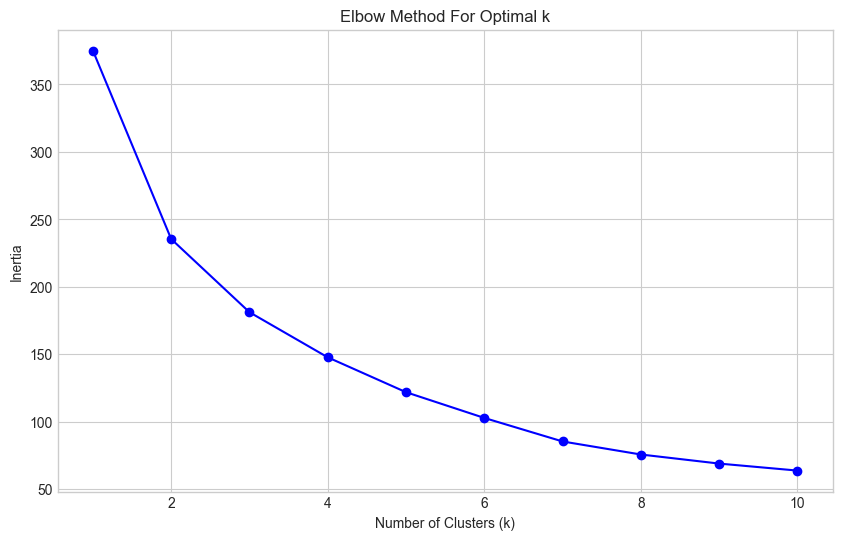

In [153]:
inertia = []
K = range(1, 11) # test k from 2 to 10

for k in K:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(scaled_features)
    inertia.append(kmeans_model.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [155]:
OPTIMAL_K = 2
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
kmeans.fit(scaled_features)

KMeans(n_clusters=2, n_init=10, random_state=42)

In [159]:
cluster_labels = kmeans.labels_

# Add the labels to the DataFrame that has the original (unscaled) feature values
# This makes analysis much easier.
# Note: We use .copy() to avoid a SettingWithCopyWarning
clustered_pairs_df = features_to_cluster.copy()
clustered_pairs_df['cluster'] = cluster_labels

In [163]:
# --- 3. Analyze the Cluster Characteristics ---
# This is the most important step: understand what each cluster represents.
print("Analyzing Cluster Centers (Mean Feature Values):")
cluster_analysis = clustered_pairs_df.groupby('cluster').mean()
cluster_analysis

Analyzing Cluster Centers (Mean Feature Values):


,half_life,spread_volatility,log_beta
cluster,,,
0,17.766655,0.061570,0.865758
1,21.125184,0.119923,1.726094


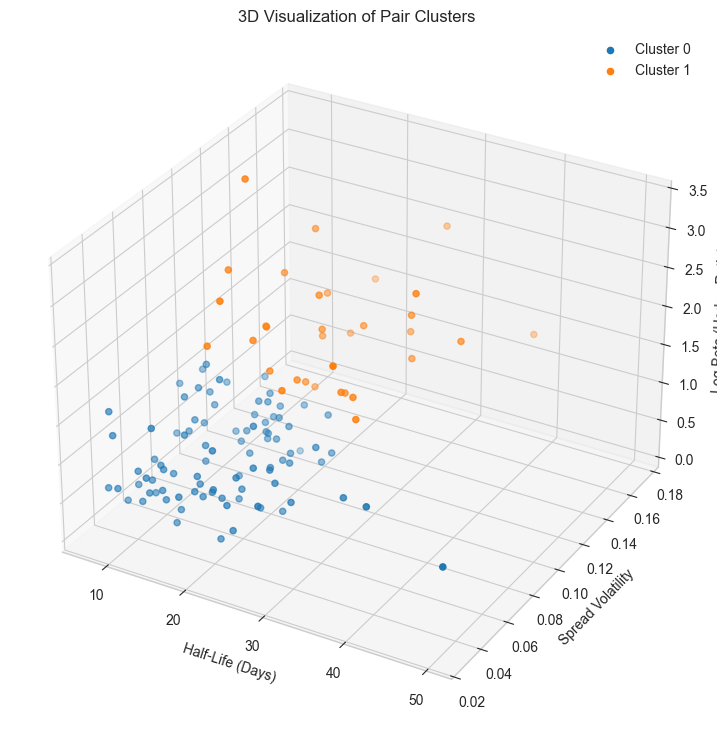

In [166]:
# --- 4. Visualize the Clusters in 3D ---
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster_num in range(OPTIMAL_K):
    cluster_data = clustered_pairs_df[clustered_pairs_df['cluster'] == cluster_num]
    ax.scatter(cluster_data['half_life'], 
               cluster_data['spread_volatility'], 
               cluster_data['log_beta'], 
               label=f'Cluster {cluster_num}')

ax.set_title('3D Visualization of Pair Clusters')
ax.set_xlabel('Half-Life (Days)')
ax.set_ylabel('Spread Volatility')
ax.set_zlabel('Log Beta (Hedge Ratio)')
ax.legend()
plt.show()